In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from image2image_reg.workflows import ValisReg
from image2image_io.readers import get_simple_reader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path = "/Users/lgmigas/Documents/_projects_/2024_hickey_kruse2/B009-reg002/pre2ims.valis"
valis = ValisReg.from_path(path)

In [4]:
reg = valis.registrar

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


JVM has been initialized. Be sure to call registration.kill_jvm() or slide_io.kill_jvm() at the end of your script.


In [20]:
modality = valis.attachment_points["statistics_analysis"]["attach_to"]
modality = valis.get_modality(modality)
slide = reg.get_slide(str(modality.path))
slide

<Slide, name = precodex>, width=10741, height=6341, channels=4, levels=4, RGB=False, dtype=uint8>

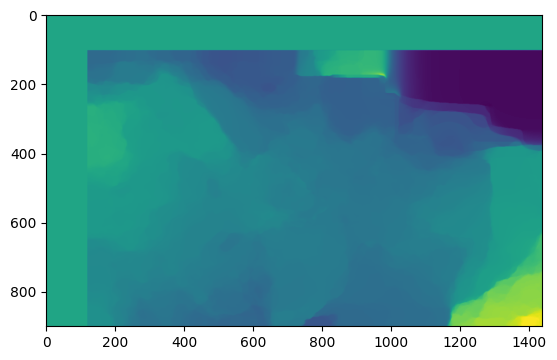

In [31]:
plt.imshow(slide.bk_dxdy[1])

In [29]:
reg.get_aligned_slide_shape(0)

array([ 7099, 11335])

In [6]:
reader = get_simple_reader(
    r"/Users/lgmigas/Documents/_projects_/2024_hickey_kruse2/B009-reg002/pre2ims.wsireg/Images/statistics_analysis_to_precodex_registered.csv"
)

In [43]:
# get coordinates of the image
x, y = reader.x, reader.y
# get slide shape
shape = slide.slide_dimensions_wh[0]
width, height = shape
# crop so that only the coordinates within the slide are kept
indices = np.where((x >= 0) & (x < width) & (y >= 0) & (y < height))
x = x[indices]
x = np.round(x).astype(int)
y = y[indices]
y = np.round(y).astype(int)
# let's create a image  of the same shape as the source image
image = np.zeros(slide.slide_shape_rc)
image[y, x] = 1

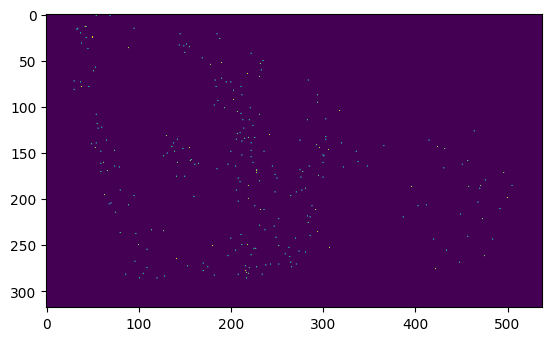

In [49]:
plt.imshow(image[::20, ::20])

In [51]:
res = slide.warp_img(image, crop="reference", interp_method="nearest")

/Users/lgmigas/Documents/GitHub/valis/valis/valtils.py:24: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and so may not overlap.
  warnings.warn(warning_msg, warning_type)


In [55]:
np.save(
    "/Users/lgmigas/Documents/_projects_/2024_hickey_kruse2/B009-reg002/pre2ims.valis/Images/statistics_analysis_to_precodex_registered-1.npy",
    image,
)

In [11]:
source_pixel_size = 0.65
is_px = source_pixel_size != 0.65

In [15]:
ref = reg.get_ref_slide()

In [16]:
ref.M

array([[  1.        ,   0.        ,  -5.58205736],
       [  0.        ,   1.        , -59.94662984],
       [  0.        ,   0.        ,   1.        ]])

In [56]:
from skimage import exposure
from image2image_reg.utils.visuals import jzazbz_cmap, create_overlap_img


def draw_overlap_img(img_list, blending="weighted"):
    """Create image showing the overlap of registered images
    blending="weighted"
    blending="light"
    """

    cmap = jzazbz_cmap()
    overlap_img = create_overlap_img(img_list, cmap=cmap, blending=blending)

    overlap_img = exposure.equalize_adapthist(overlap_img)
    overlap_img = exposure.rescale_intensity(overlap_img, out_range=(0, 255)).astype(np.uint8)
    return overlap_img

(100, 100) True
(100, 100) True


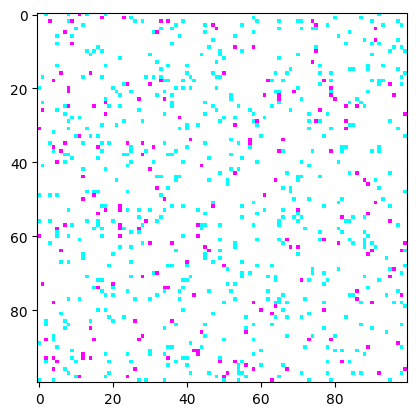

In [224]:
image1 = np.random.rand(100, 100, 3) * 255
image2 = np.random.rand(100, 100, 3) * 255
image3 = np.random.rand(100, 100, 3) * 255
image4 = np.random.rand(100, 100, 3) * 255
res = create_overlap_img([image1, image3])  # , image3, image4])
plt.imshow(res)

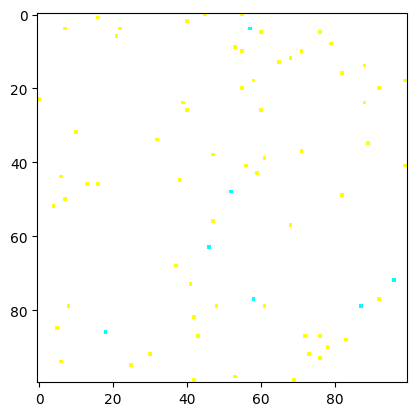

In [169]:
from image2image_reg.workflows import ElastixReg
import SimpleITK as sitk
from skimage.color import rgb2gray
from valis.viz import create_overlap_img as create_overlap_img_valis

In [ ]:
path = r"/Users/lgmigas/Documents/_projects_/2024_hickey_kruse2/B009-reg002/pre2ims.wsireg"
elastix = ElastixReg.from_path(path)

In [264]:
elastix.preview()

In [247]:
for source, target_pair in elastix.registration_paths.items():
    print(source, target_pair)

precodex ['he']


In [71]:
elastix.get_image_modalities(with_attachment=False)

['he', 'precodex']

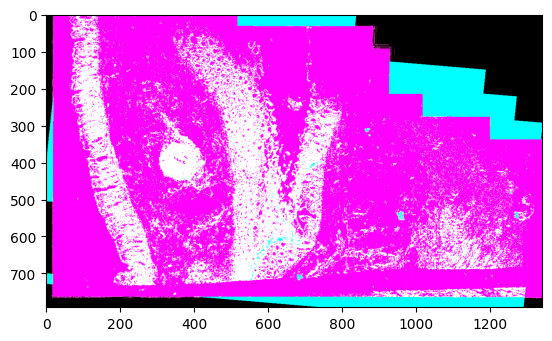

In [262]:
for res in elastix._generate_overlap_image():
    plt.imshow(res)

In [238]:
def transform_images(wrapper, transformations, pyramid=-1):
    """Transform all images."""
    transformed = []
    reader = wrapper.reader
    channel_axis, n_channels = reader.get_channel_axis_and_n_channels()
    for channel_index in reader.channel_ids:
        image = np.squeeze(reader.get_channel(channel_index, pyramid, split_rgb=True))
        image = sitk.GetImageFromArray(image)
        image.SetSpacing(reader.scale_for_pyramid(pyramid))
        transformed.append(sitk.GetArrayFromImage(transformations(image)))
    transformed = np.stack(transformed, axis=channel_axis)
    return transformed


transform_images(he, transformations).shape, he.reader.shape

((792, 1342, 3), (6341, 10741, 3))

In [72]:
he = elastix.get_wrapper("he")
precodex = elastix.get_wrapper("precodex")

In [119]:
he_ch = he.reader.get_channel(0, -1)
he_ch = he.reader.pyramid[-1]
codex_ch = precodex.reader.get_channel(0, -1)
codex_ch = precodex.reader.pyramid[-1]

In [120]:
to_transform, _, _ = elastix._get_modalities_to_transform()

In [121]:
modality, transformations, filename = elastix._prepare_registered_transform("precodex")

In [123]:
he_ch_sitk = sitk.GetImageFromArray(he_ch[:, :, 0])
he_ch_sitk.SetSpacing(he.reader.scale_for_pyramid(-1))
# codex_ch_sitk = sitk.GetImageFromArray(codex_ch)
# codex_ch_sitk.SetSpacing((4, *precodex.reader.scale_for_pyramid(-1)))

In [126]:
transformations.set_output_spacing(he_ch_sitk.GetSpacing(), he_ch_sitk.GetSize())

In [134]:
codex_ch_sitk2 = []
for index in range(4):
    codex_ch_sitk2.append(sitk.GetArrayFromImage(transformations(sitk.GetImageFromArray(codex_ch[index]))))
codex_ch_sitk2 = np.stack(codex_ch_sitk2, axis=-1)
codex_ch_sitk2 = np.moveaxis(codex_ch_sitk2, 2, 0)

((4, 792, 1342), (792, 1342, 3))

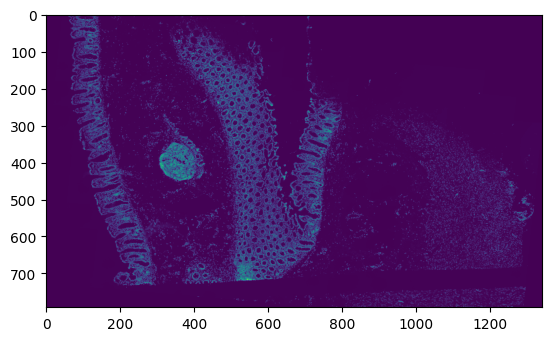

In [103]:
plt.imshow(sitk.GetArrayFromImage(codex_ch_sitk2))

In [145]:
codex_ch_sitk2[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

[[ 1.          0.24286805  0.73575483]
 [ 0.05614369  0.96593684  0.30576677]]
[array([[[ 15344.49945839,  20550.52858682,  -5875.7378323 ]]]), array([[[ 21770.53720231, -20378.77659591,  16445.99382482]]])]


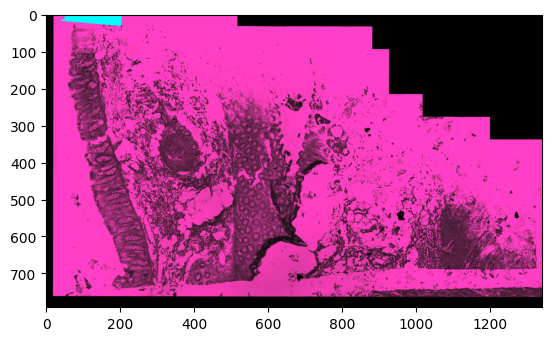

In [193]:
# res = create_overlap_img([np.asarray(he_ch[:,:,2]), codex_ch_sitk2[1]])
res = create_overlap_img([np.asarray(he_ch), codex_ch_sitk2])
plt.imshow(res, vmax=0.2)

In [191]:
np.asarray([1.0, 0.24286805, 0.73575483]) * 255

array([ 255.        ,   61.93135275,  187.61748165])

In [187]:
(codex_ch_sitk2[0] / 190).max()

0.98421052631578942

[[ 1.          0.24286805  0.73575483]
 [ 0.05614369  0.96593684  0.30576677]]
[array([[[ 15344.49945839,  20550.52858682,  -5875.7378323 ]]]), array([[[ 21770.53720231, -20378.77659591,  16445.99382482]]])]


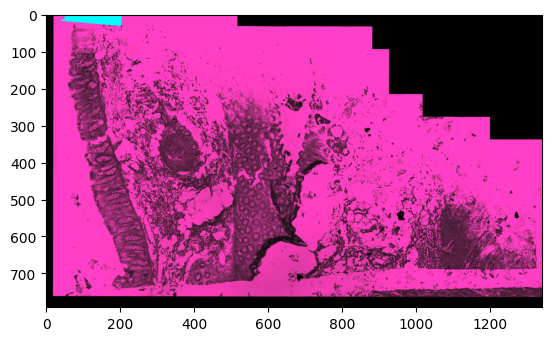

In [197]:
res = create_overlap_img([np.asarray(he_ch), np.flipud(codex_ch_sitk2)])
plt.imshow(res)

In [265]:
norms = np.load(r"/Users/lgmigas/Downloads/2024-09-26-normalizations.npy")

In [283]:
n_orders = 2
norm = norms[5]
norm = np.log10(norm + 1)
mask = norm < (norm.max() - n_orders)
np.sum(mask)

2